In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from functools import reduce
from scipy.io import loadmat
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(1)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


1


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 116 seconds


In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    ''' Standard bottleneck block
    input  = inplanes * H * W
    middle =   planes * H/stride * W/stride
    output = 4*planes * H/stride * W/stride
    '''
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=dilation, dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


def reset_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()


class ResNet(nn.Module):
    """ A standard ResNet.
    """
    def __init__(self, block, layers, fc_out, model_name, self_similarity_radius=None, self_similarity_version=2):
        nn.Module.__init__(self)
        self.model_name = model_name

        # default values for a network pre-trained on imagenet
        self.rgb_means = [0.485, 0.456, 0.406]
        self.rgb_stds  = [0.229, 0.224, 0.225]
        self.input_size = (3, 224, 224)

        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], self_similarity_radius=self_similarity_radius, self_similarity_version=self_similarity_version)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, self_similarity_radius=self_similarity_radius, self_similarity_version=self_similarity_version)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, self_similarity_radius=self_similarity_radius, self_similarity_version=self_similarity_version)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, self_similarity_radius=self_similarity_radius, self_similarity_version=self_similarity_version)

        reset_weights(self)

        self.fc = None
        self.fc_out = fc_out
        if self.fc_out > 0:
            self.avgpool = nn.AdaptiveAvgPool2d(1)
            self.fc = nn.Linear(512 * block.expansion, fc_out)
            self.fc_name = 'fc'

    def _make_layer(self, block, planes, blocks, stride=1, self_similarity_radius=None, self_similarity_version=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes=planes, stride=stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        if self_similarity_radius:
            if self_similarity_version == 1:
                from . self_sim import SelfSimilarity1
                layers.append(SelfSimilarity1(self_similarity_radius, self.inplanes))
            else:
                from . self_sim import SelfSimilarity2
                layers.append(SelfSimilarity2(self_similarity_radius, self.inplanes))
        return nn.Sequential(*layers)

    def forward(self, x, out_layer=0):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if out_layer==-1:
            return x, self.layer4(x)
        x = self.layer4(x)

        if self.fc_out > 0:
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            
        return x

    def load_pretrained_weights(self, pretrain_code):
        if pretrain_code == 'imagenet':
            model_urls = {
                'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
                'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
                'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
                'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
            }
        else:
            raise NameError("unknown pretraining code '%s'" % pretrain_code)

        print("Loading ImageNet pretrained weights for %s" % pretrain_code)
        assert self.model_name in model_urls, "Unknown model '%s'" % self.model_name

        model_dir='dirtorch/data/models/classification/'
        import os, stat # give group permission
        try: os.makedirs(model_dir)
        except OSError: pass

        import torch.utils.model_zoo as model_zoo
        state_dict = model_zoo.load_url(model_urls[self.model_name], model_dir=model_dir)

        from . import load_pretrained_weights
        load_pretrained_weights(self, state_dict)


def resnet18(out_dim=2048, n_cls=0):
    """Constructs a ResNet-18 model.
    """
    net = ResNet(BasicBlock, [2, 2, 2, 2], out_dim, 'resnet18', n_cls=0)
    return net

def resnet50(out_dim=2048, n_cls=0):
    """Constructs a ResNet-50 model.
    """
    net = ResNet(Bottleneck, [3, 4, 6, 3], out_dim, 'resnet50', n_cls=0)
    return net

def resnet101(out_dim=2048, n_cls=0):
    """Constructs a ResNet-101 model.
    """
    net = ResNet(Bottleneck, [3, 4, 23, 3], out_dim, 'resnet101', n_cls=0)
    return net

def resnet152(out_dim=2048, n_cls=0):
    """Constructs a ResNet-152 model.
    """
    net = ResNet(Bottleneck, [3, 8, 36, 3], out_dim, 'resnet152', n_cls=0)
    return net

In [4]:
class GeneralizedMeanPooling(nn.Module):
    r"""Applies a 2D power-average adaptive pooling over an input signal composed of several input planes.
    The function computed is: :math:`f(X) = pow(sum(pow(X, p)), 1/p)`
        - At p = infinity, one gets Max Pooling
        - At p = 1, one gets Average Pooling
    The output is of size H x W, for any input size.
    The number of output features is equal to the number of input planes.
    Args:
        output_size: the target output size of the image of the form H x W.
                     Can be a tuple (H, W) or a single H for a square image H x H
                     H and W can be either a ``int``, or ``None`` which means the size will
                     be the same as that of the input.
    """

    def __init__(self, norm, output_size=1, eps=1e-6):
        super(GeneralizedMeanPooling, self).__init__()
        assert norm > 0
        self.p = float(norm)
        self.output_size = output_size
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        return F.adaptive_avg_pool2d(x, self.output_size).pow(1. / self.p)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + str(self.p) + ', ' \
            + 'output_size=' + str(self.output_size) + ')'



class GeneralizedMeanPoolingP(GeneralizedMeanPooling):
    """ Same, but norm is trainable
    """
    def __init__(self, norm=3, output_size=1, eps=1e-6):
        super(GeneralizedMeanPoolingP, self).__init__(norm, output_size, eps)
        self.p = nn.Parameter(torch.ones(1) * norm)

In [5]:
#https://github.com/almazan/deep-image-retrieval
def l2_normalize(x, axis=-1):
    x = F.normalize(x, p=2, dim=axis)
    return x


class ResNet_RMAC_FPN(ResNet):
    """ ResNet for RMAC (without ROI pooling)
    """
    def __init__(self, block, layers, model_name, out_dim=None, norm_features=False,
                       pooling='gem', gemp=3, center_bias=0, mode=1, n_cls=0,
                       dropout_p=None, without_fc=False, **kwargs):
        ResNet.__init__(self, block, layers, 0, model_name, **kwargs)
        self.norm_features = norm_features
        self.without_fc = without_fc
        self.pooling = pooling
        self.center_bias = center_bias
        self.mode = mode
        self.n_cls = n_cls

        dim1 = 256 * block.expansion
        dim2 = 512 * block.expansion
        if out_dim is None: out_dim = dim1 + dim2
        #FPN
        if self.mode == 1:
            self.conv1x5 = nn.Conv2d(dim2, dim1, kernel_size=1, stride=1, bias=False)
            self.conv3c4 = nn.Conv2d(dim1, dim1, kernel_size=3, stride=1, padding=1, bias=False)
            self.relu = nn.ReLU(inplace=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

        if pooling == 'max':
            self.adpool = nn.AdaptiveMaxPool2d(output_size=1)
        elif pooling == 'avg':
            self.adpool = nn.AdaptiveAvgPool2d(output_size=1)
        elif pooling == 'gem':
            self.adpoolx5 = GeneralizedMeanPoolingP(norm=gemp)
            self.adpoolc4 = GeneralizedMeanPoolingP(norm=gemp)

        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.fc = nn.Linear(768 * block.expansion, out_dim)
        self.fc_name = 'fc'
        self.feat_dim = out_dim
        self.detach = False

    def forward(self, x):
        x4, x5 = ResNet.forward(self, x, -1)
        
        if self.n_cls: 
            x = nn.Linear(x5, self.n_cls) #for classification
            return x

        # FPN
        if self.mode == 1:
            c5 = F.interpolate(x5, size=x4.shape[-2:], mode='nearest')

            c5 = self.conv1x5(c5)
            c5 = self.relu(c5)
            x4 = x4 + c5
            x4 = self.conv3c4(x4)
            x4 = self.relu(x4)

        if self.dropout is not None:
            x5 = self.dropout(x5)
            x4 = self.dropout(x4)

        if self.detach:
            # stop the back-propagation here, if needed
            x5 = Variable(x5.detach())
            x5 = self.id(x5)  # fake transformation
            x4 = Variable(x4.detach())
            x4 = self.id(x4)  # fake transformation

        # global pooling
        x5 = self.adpoolx5(x5)
        x4 = self.adpoolc4(x4)

        x = torch.cat((x4, x5), 1)

        if self.norm_features:
            x = l2_normalize(x, axis=1)

        x.squeeze_()
        if not self.without_fc:
            x = self.fc(x)

        x = l2_normalize(x, axis=-1)
        return x


def resnet18_fpn_rmac(backbone=ResNet_RMAC_FPN, **kwargs):
    kwargs.pop('scales', None)
    return backbone(BasicBlock, [2, 2, 2, 2], 'resnet18', **kwargs)

def resnet50_fpn_rmac(backbone=ResNet_RMAC_FPN, **kwargs):
    kwargs.pop('scales', None)
    return backbone(Bottleneck, [3, 4, 6, 3], 'resnet50', **kwargs)

def resnet101_fpn_rmac(backbone=ResNet_RMAC_FPN, n_cls=0, **kwargs):
    kwargs.pop('scales', None)
    return backbone(Bottleneck, [3, 4, 23, 3], 'resnet101', n_cls=0, **kwargs)

def resnet101_fpn0_rmac(backbone=ResNet_RMAC_FPN, **kwargs):
    kwargs.pop('scales', None)
    return backbone(Bottleneck, [3, 4, 23, 3], 'resnet101', mode=0, **kwargs)

def resnet152_fpn_rmac(backbone=ResNet_RMAC_FPN, **kwargs):
    kwargs.pop('scales', None)
    return backbone(Bottleneck, [3, 8, 36, 3], 'resnet152', **kwargs)

 328 / 328 : loss = 7.358504Eopch:     1 mean_loss = 7.332083
 328 / 328 : loss = 7.377118Eopch:     2 mean_loss = 7.320675
 328 / 328 : loss = 7.324796Eopch:     3 mean_loss = 7.313577
 328 / 328 : loss = 7.325956Eopch:     4 mean_loss = 7.313781
 328 / 328 : loss = 7.329516Eopch:     5 mean_loss = 7.318512
 328 / 328 : loss = 7.308834Eopch:     6 mean_loss = 7.318499
 328 / 328 : loss = 7.373113Eopch:     7 mean_loss = 7.317751
 328 / 328 : loss = 7.265966Eopch:     8 mean_loss = 7.312011
 328 / 328 : loss = 7.371287Eopch:     9 mean_loss = 7.301290
 328 / 328 : loss = 7.328485Eopch:    10 mean_loss = 7.300957
best_loss = 7.300957
 36 / 37 Sensitivity(TPR) of Benign: 0.250000
Sensitivity(TPR) of Malignant: 0.865285
AUC (Area Under Curve) of Micro: 0.584769


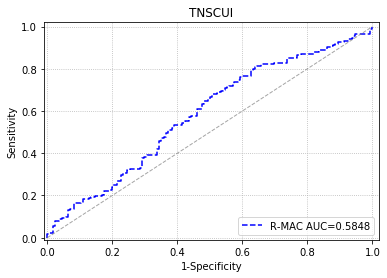

In [13]:
#define model
model = resnet101_fpn_rmac(n_cls=2).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        Out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = ce_loss(Out_batch,Y_batch)#loss
        #backward
        loss.backward()
        optimizer.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
torch.cuda.empty_cache()

#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Benign: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Malignant: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('TNSCUI')
plt.show()

In [14]:
#release gpu memory and save model in CPU
model = model.cpu()
ce_loss = ce_loss.cpu()
best_net = best_net.cpu()
torch.cuda.empty_cache() 
torch.save(best_net.state_dict(), '/data/tmpexec/R_MAC.pkl')

In [15]:
#load model and transfer to GPU
device = torch.device("cuda")
best_net = resnet101_fpn_rmac(n_cls=0)
best_net.load_state_dict(torch.load( '/data/tmpexec/R_MAC.pkl'))
best_net.to(device)

#Extract features based on backbone and Aggregate R-MAC+FPN
batchSize=10
trF = []
num_batches = len(trI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(out_batch.detach().cpu().numpy().tolist())
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(out_batch.detach().cpu().numpy().tolist())
    
#compute the size of lesion
def Func_IOU_size(pred,target):
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(3072) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

Completed buliding index in 23 seconds
mAP=0.3598, mIoU=0.3930


In [39]:
print(out_batch.shape)

torch.Size([5, 3072])
